#### 1. Why should outlier be picked out and cleaned? 
Ans: First, there are some empty data, these data can lead to a false result. Secondly, because of the particularity of this set of data, some special data should be especially observed. In particular, some actions like conversation, onset of a disease can influence the veracity of the experiment

In [1]:
import pandas as pd
import os
import re
import numpy as np
from six.moves import xrange
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope

In [2]:
def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def abs_cos_vector1(v1, v2):
    return abs(dotproduct(v1, v2) / length(v2))

def calc_force(df):
    df['force'] = df['Fx']**2 + df['Fy']**2 + df['Fz']**2
    df['force'] = df['force'].pow(1/2)
    return df

def calc_velocity(df):
    df['velocity'] = df['Lx']**2 + df['Ly']**2 + df['Lz']
    df['velocity'] = df['velocity'].pow(1/2)
    return df
    
def calc_score(df, factor=2):
    df['score'] = df['front']*df['velocity']/factor
    return df

def time_to_sec(time):
    tmp = time.split(':')
    mins = tmp[0]
    secs = tmp[1]
    return timedelta(minutes=int(mins), seconds=int(secs)).total_seconds()

def find_data(df, uid=None, day=None, exc_num=None, exc_times=None):
    if uid is not None:
        df = df[df['uid']==uid]
        
    if day is not None:
        df = df[df['day']==day]
        
    if exc_num is not None:
        df = df[df['exc_num']==exc_num]
        
    if exc_times is not None:
        df = df[df['exc_times']==exc_times]
        

In [3]:
df = pd.read_csv('../data/all_data1.csv')
df = calc_force(df)
df = calc_velocity(df)
df = calc_score(df)
df = df.drop(['left', 'right', 'Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz','Fx.1', 'Fy.1', 'Fz.1', 
                      'Mx.1', 'My.1', 'Mz.1','Lx', 'Ly', 'Lz', 'Ax', 'Ay', 'Az'], axis=1)

# 1. Generate data

calculate length of each data file

In [4]:
df_len = df[['uid', 'day', 'exc_num', 'exc_times']].groupby(['uid', 'day', 'exc_num', 'exc_times']).apply(lambda x: len(x))
df_len = df_len.reset_index()
df_len.columns = ['uid', 'day', 'exc_num', 'exc_times', 'length']
df_len.head()

,uid,day,exc_num,exc_times,length
0,1,1,1.1,1,3667
1,1,1,1.1,2,2955
2,1,1,1.2,1,3903
3,1,1,1.2,2,3143
4,1,1,1.2,3,3383


delete empty data and show their number below

In [5]:
threshold = 10
print('the length before cleaning: ' + str(len(df_len)))
outlier_empty = df_len[df_len['length']<=threshold]
df_without_empty = df_len[df_len['length']>threshold]

print('the length after cleaning: ' + str(len(df_without_empty)))
outlier_empty.head()

the length before cleaning: 916
the length after cleaning: 875


,uid,day,exc_num,exc_times,length
22,1,2,1.1,1,1
23,1,2,1.1,2,1
24,1,2,1.2,1,1
25,1,2,1.2,2,1
26,1,2,1.2,3,1


# 2. Observe data
comparison of all training time (length of each exercise file) 

[Text(0.5,0,'exercise index')]

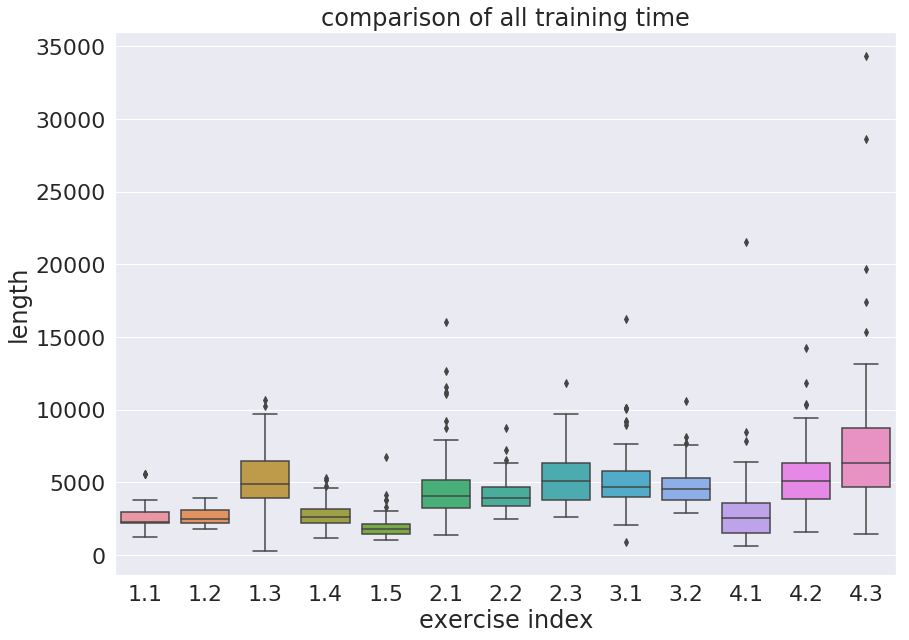

In [6]:
df_len_by_exc_num = df_without_empty[['exc_num', 'length']]

sns.set_style('whitegrid')
sns.set(font_scale=2)
f, ax= plt.subplots(figsize = (14, 10))

ax = sns.boxplot(x="exc_num", y="length", data=df_len_by_exc_num)
ax.set_title('comparison of all training time')
ax.set(xlabel='exercise index')

 comparison of training time by each person

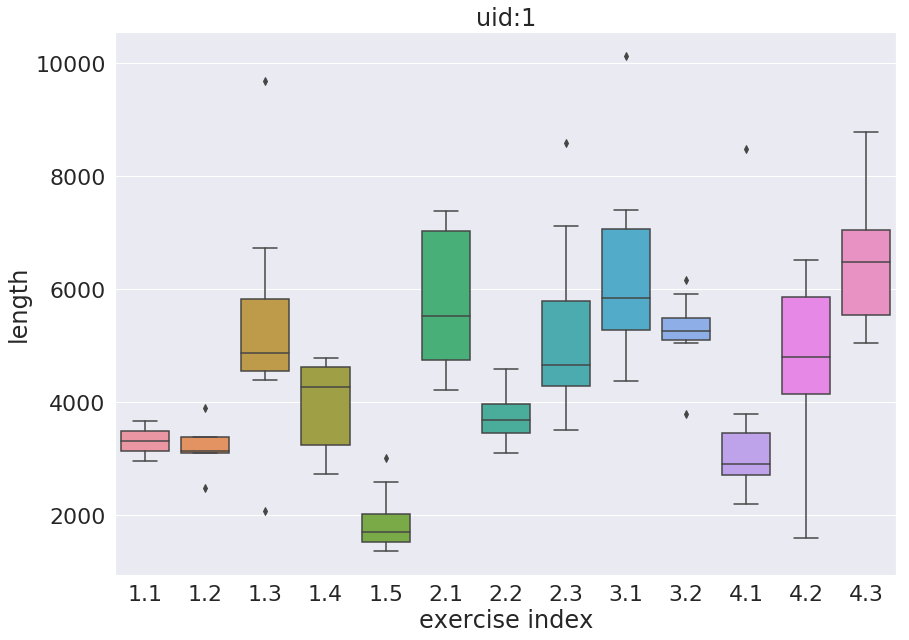

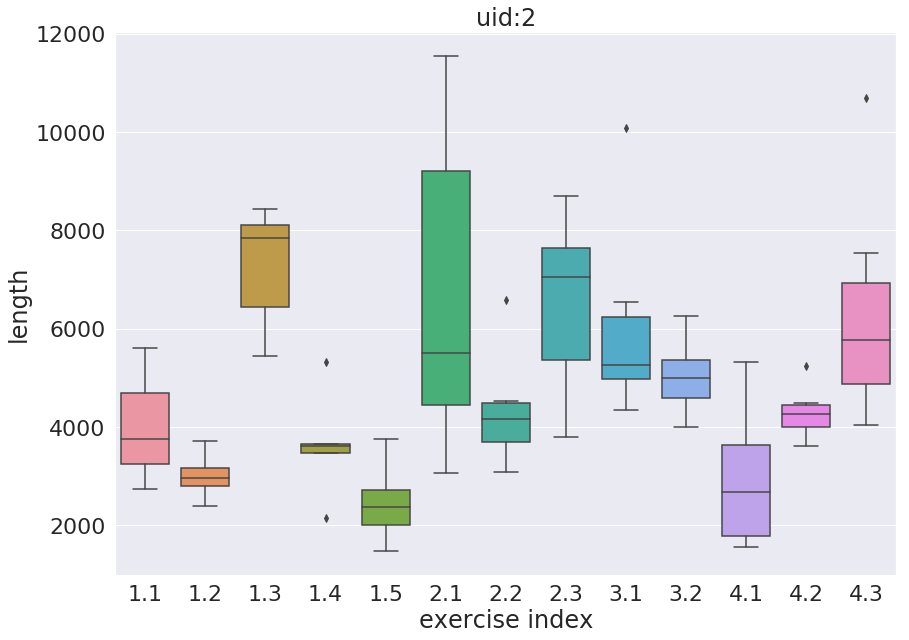

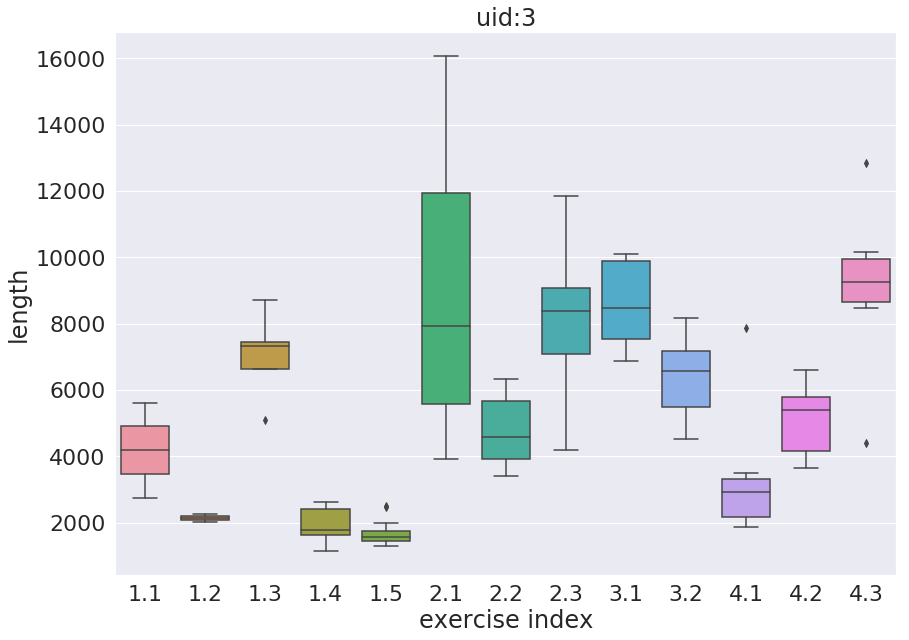

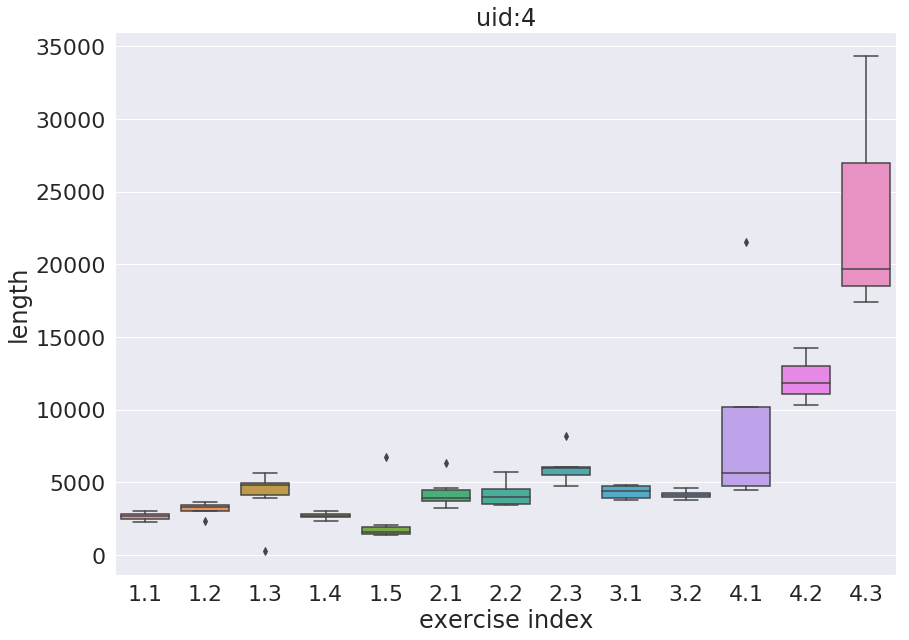

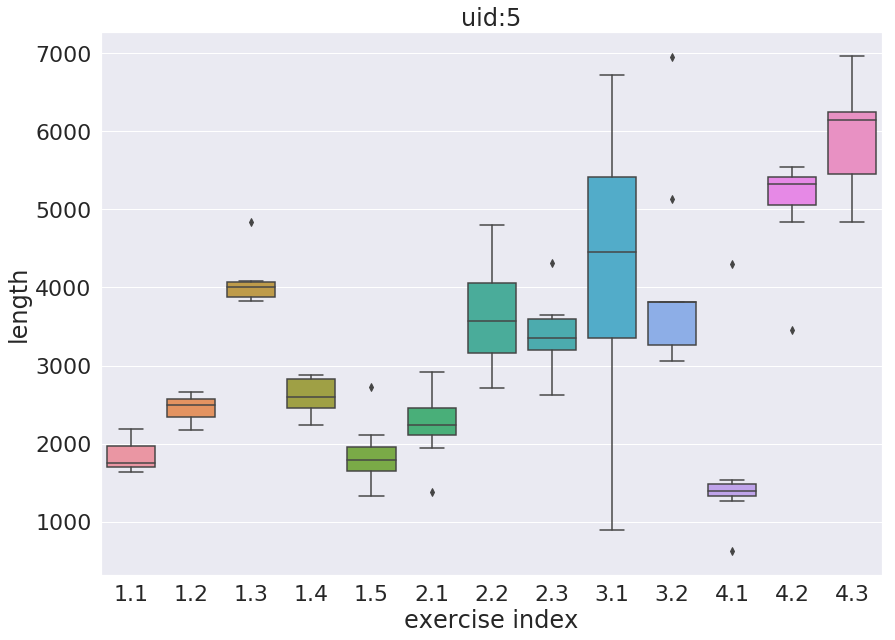

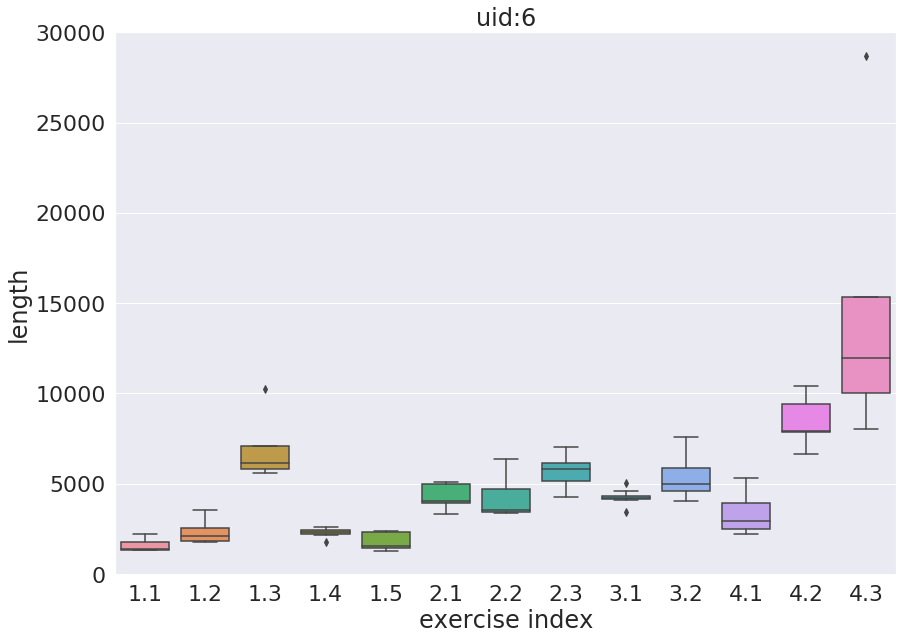

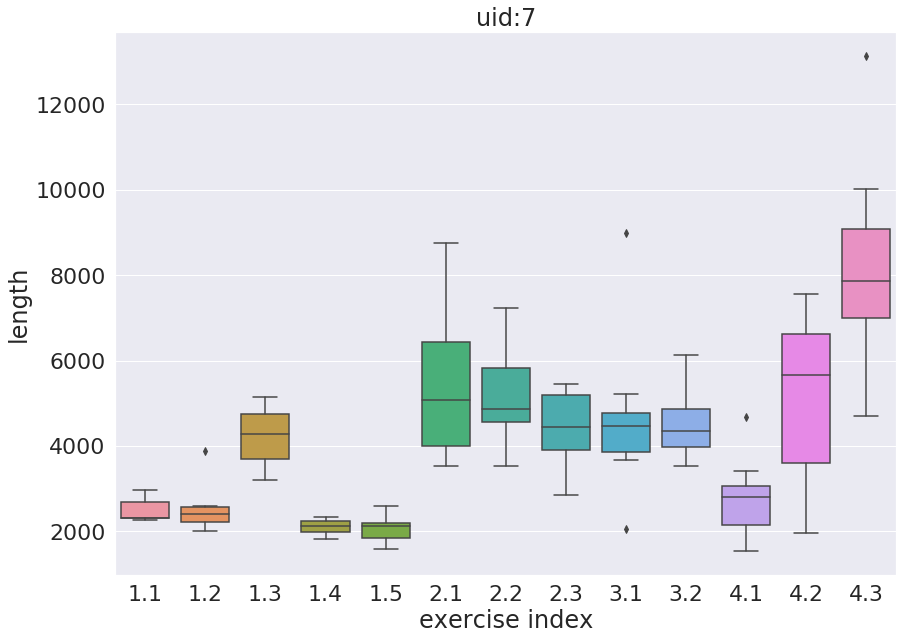

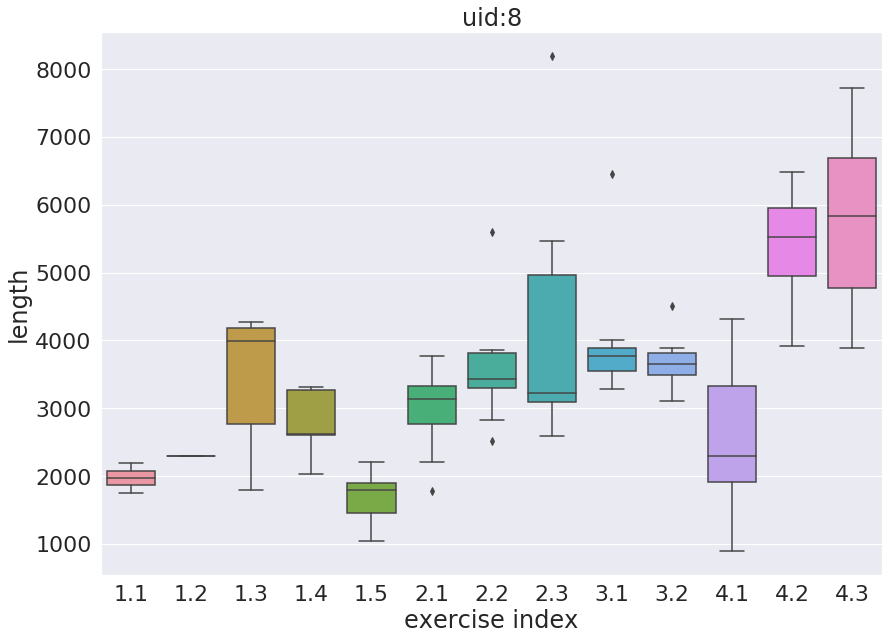

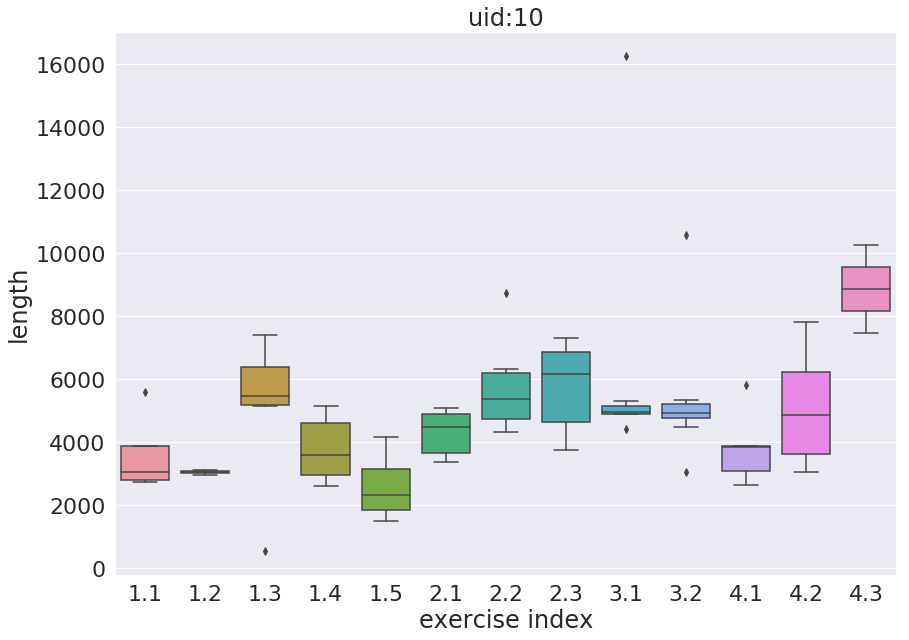

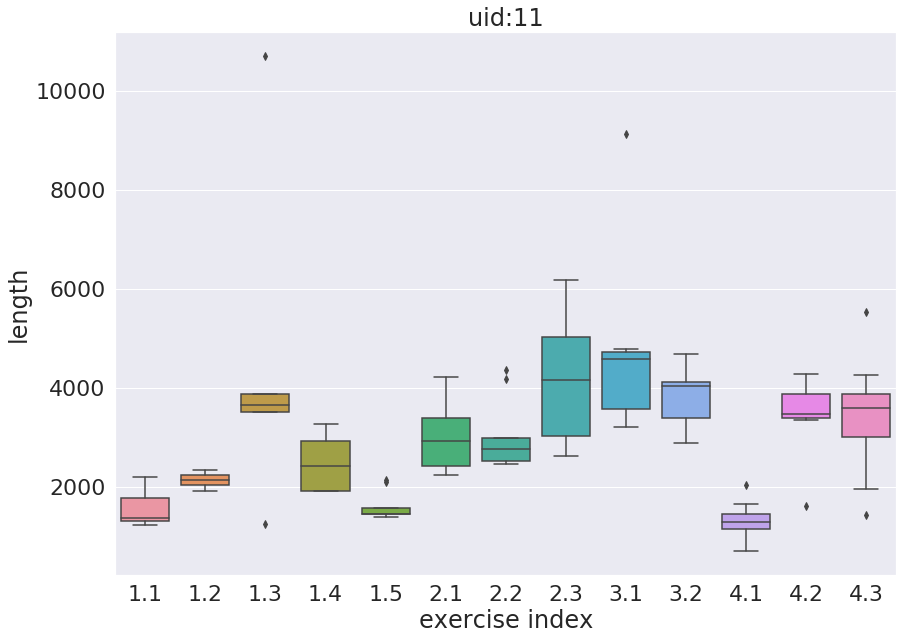

In [7]:
data = df_without_empty[['uid', 'exc_num', 'length']]
people = df_without_empty['uid'].unique().tolist()
for person in people:
    
    sns.set_style('whitegrid')
    sns.set(font_scale=2)
    f, ax= plt.subplots(figsize = (14, 10))
    tmp = df_without_empty[df_without_empty['uid']==person]
    ax = sns.boxplot(x="exc_num", y="length", data=tmp)
    ax.set_title('uid:'+str(person))
    ax.set(xlabel='exercise index')

# 3. Clean outlier

initialize 

In [8]:
data = df_without_empty[['uid', 'exc_num', 'length', 'day', 'exc_times']]
people = df_without_empty['uid'].unique().tolist()
exc = df_without_empty['exc_num'].unique().tolist()
data = data.set_index(['exc_num'])

check ineffective data under all data 

In [9]:
grouped = data.groupby(by=data.index)
tmp = pd.DataFrame()

for index, group in grouped:
    clf = EllipticEnvelope(contamination=0.1)
    clf.fit(data.loc[index,'length'].as_matrix().reshape(-1, 1))
    mask = clf.predict(data.loc[index,'length'].as_matrix().reshape(-1, 1))
    group['global'] = mask
    tmp = pd.concat([tmp, group])
    
data = tmp
tmp.head()    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,uid,length,day,exc_times,global
exc_num,,,,,
1.1,1,3667,1,1,1
1.1,1,2955,1,2,1
1.1,2,5614,1,1,-1
1.1,2,2742,1,2,1
1.1,2,3763,1,3,1


check ineffective data under each user data 

In [10]:
tmp = pd.DataFrame()
for person in people: 
    tmp_person = data[data['uid']==person]
    grouped = tmp_person.groupby(tmp_person.index)
    

    for index, group in grouped:
        clf = EllipticEnvelope(contamination=0.1)
        if len(group)==1:
            group['user_mask'] = 1
        else:
            clf.fit(tmp_person.loc[index,'length'].as_matrix().reshape(-1, 1))
            mask = clf.predict(tmp_person.loc[index,'length'].as_matrix().reshape(-1, 1))
            group['user_mask'] = mask
        tmp = pd.concat([tmp, group])

data = tmp
tmp.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

,uid,length,day,exc_times,global,user_mask
exc_num,,,,,,
1.1,1,3667,1,1,1,1
1.1,1,2955,1,2,1,1
1.2,1,3903,1,1,-1,1
1.2,1,3143,1,2,1,1
1.2,1,3383,1,3,1,1


# 4. Observe data after cleaning 

initialize data 

In [11]:
global_cleaned_data = data[data['global']>0]
user_cleaned_data = data[data['user_mask']>0]

comparison of all training time (length of each exercise file)  

[Text(0.5,0,'exercise index')]

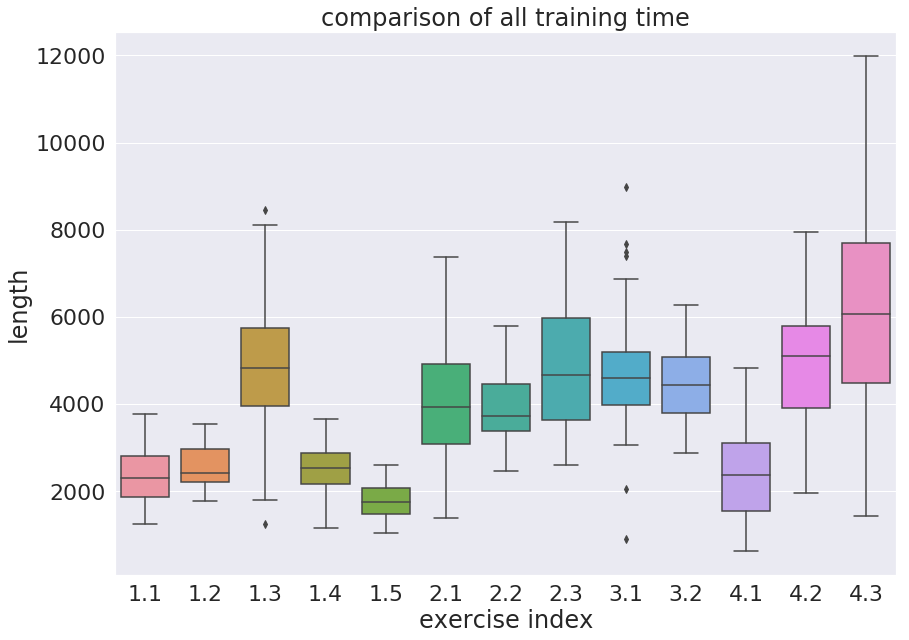

In [12]:
df_len_by_exc_num = global_cleaned_data.reset_index()[['exc_num', 'length']]

sns.set_style('whitegrid')
sns.set(font_scale=2)
f, ax= plt.subplots(figsize = (14, 10))

ax = sns.boxplot(x="exc_num", y="length", data=df_len_by_exc_num)
ax.set_title('comparison of all training time')
ax.set(xlabel='exercise index')

comparison of training time by each person 

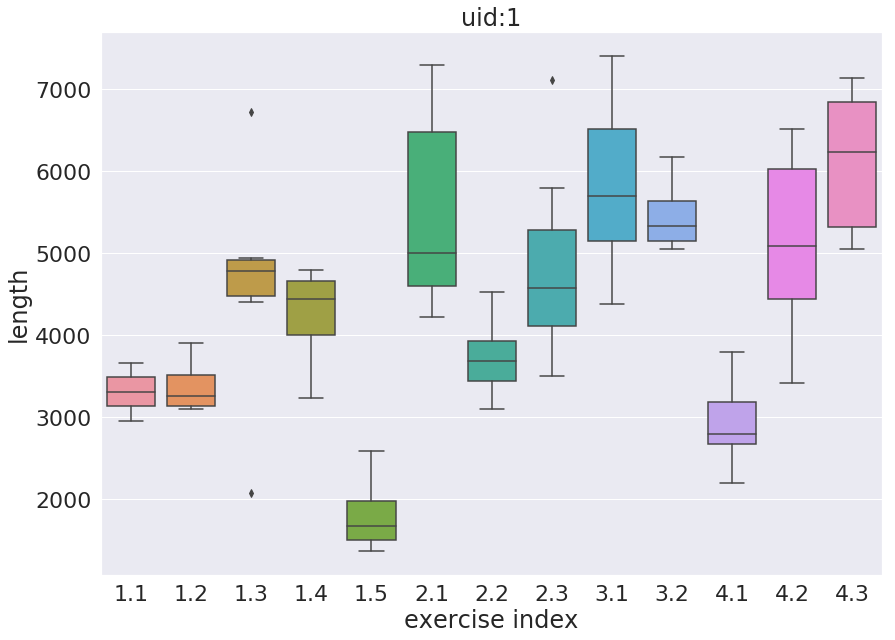

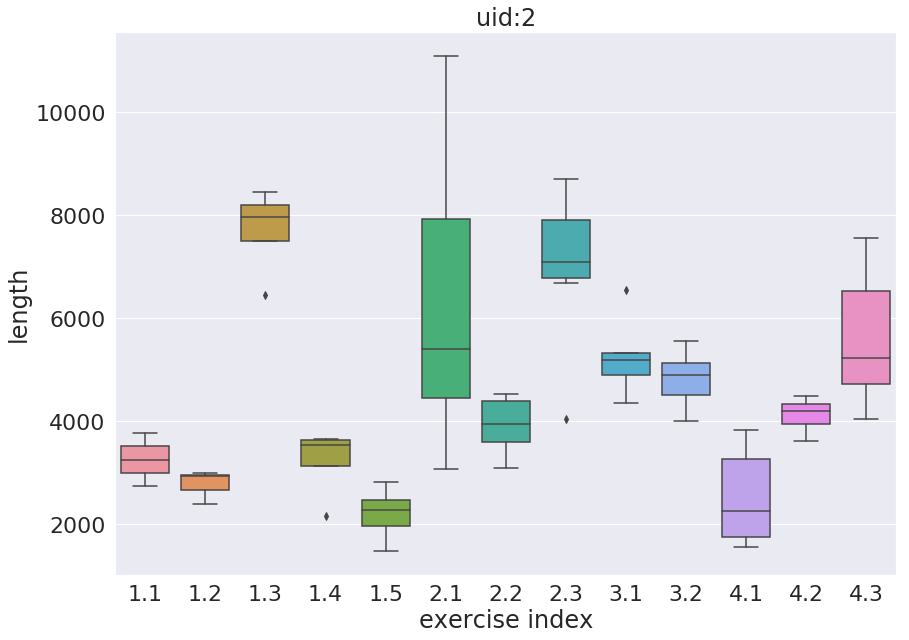

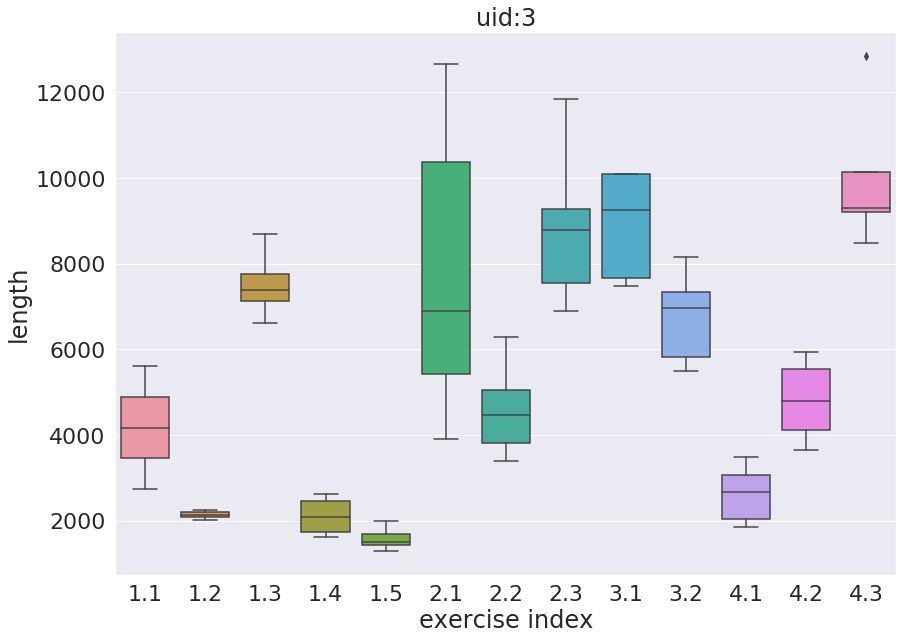

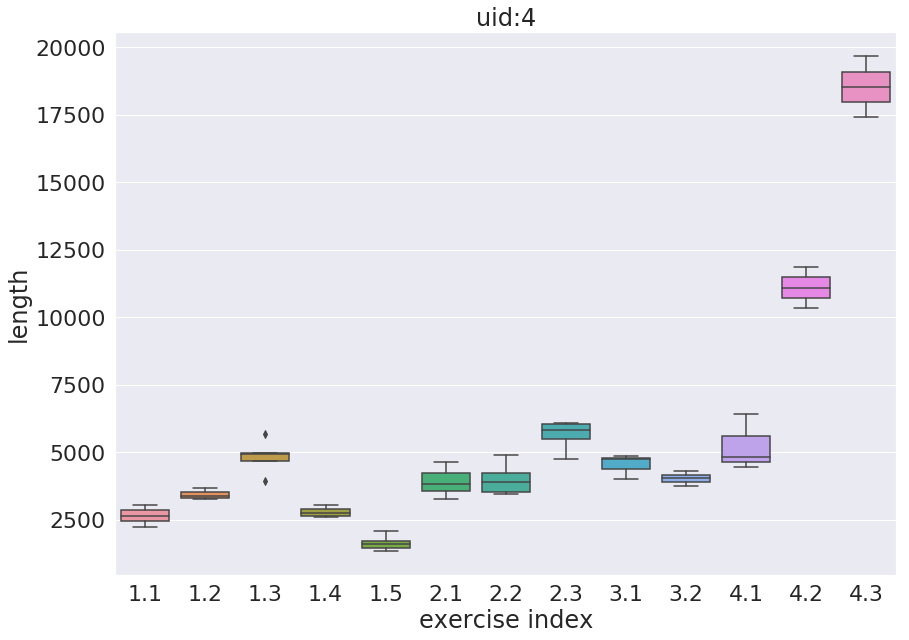

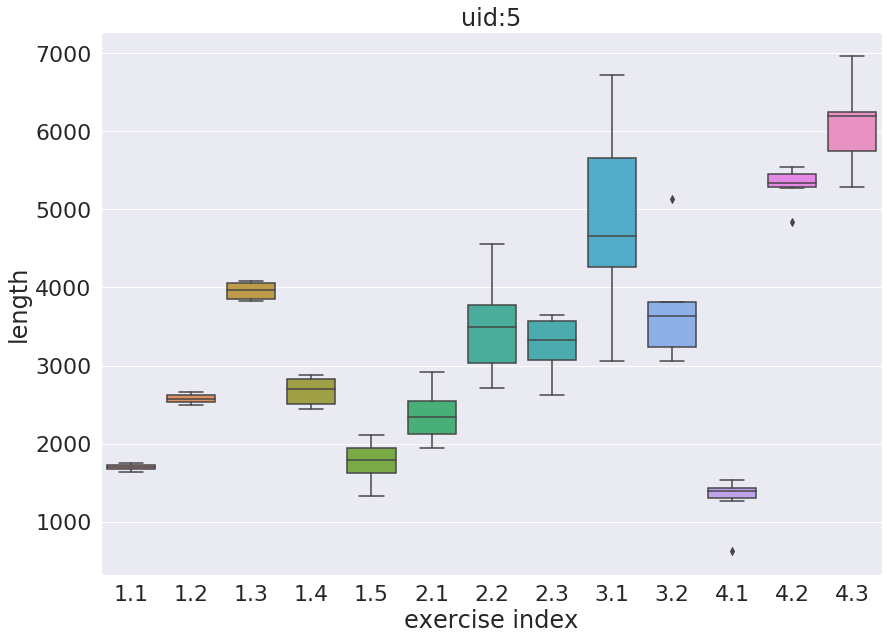

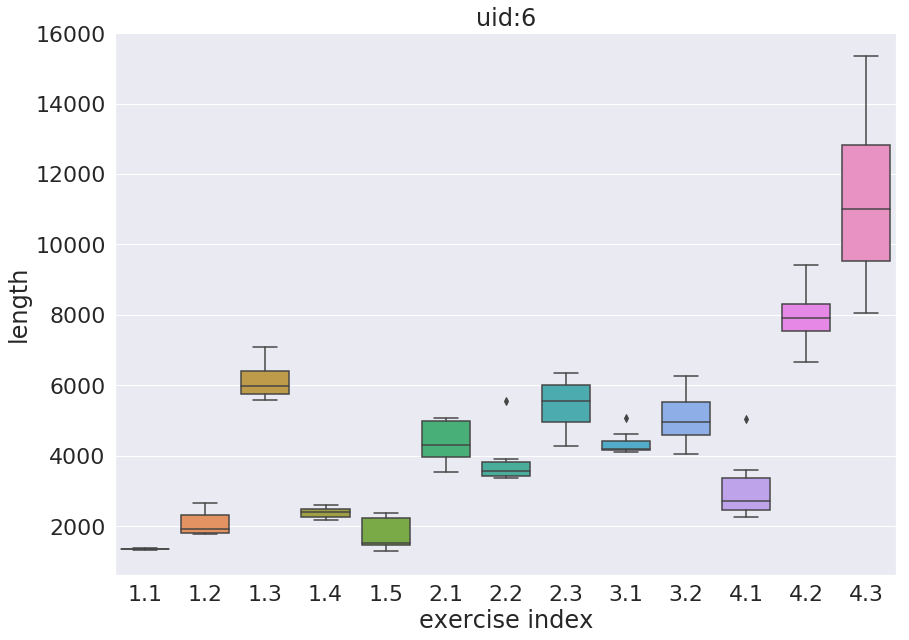

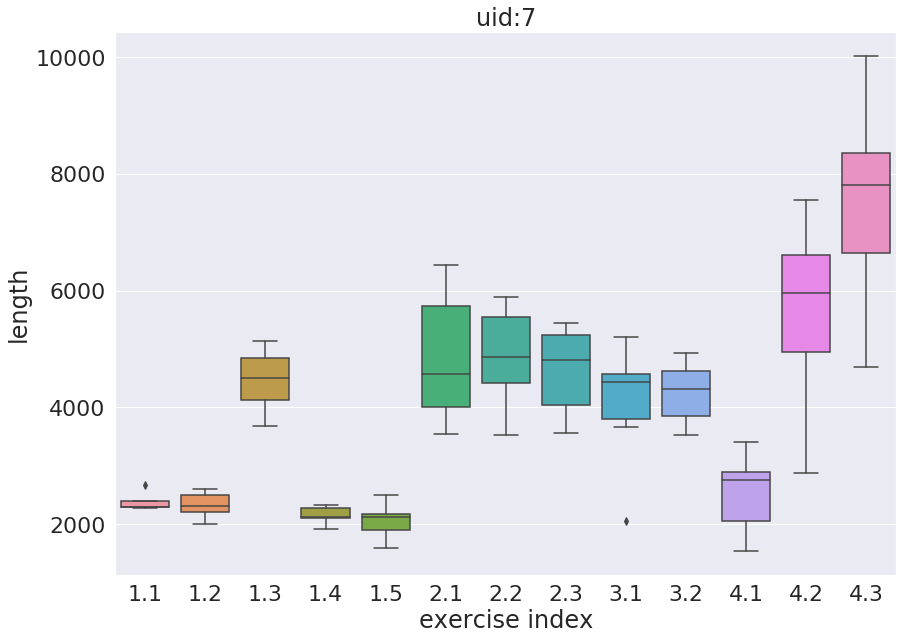

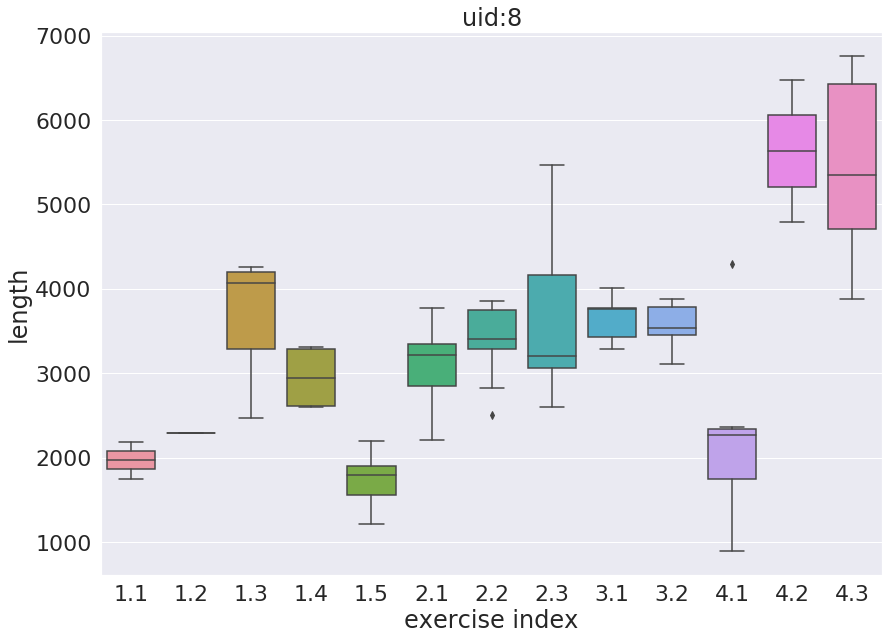

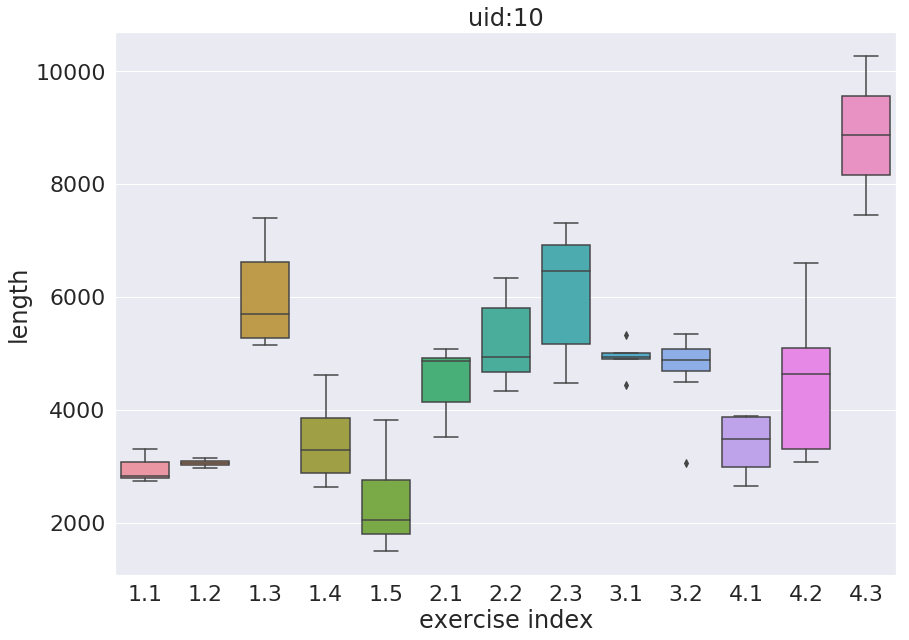

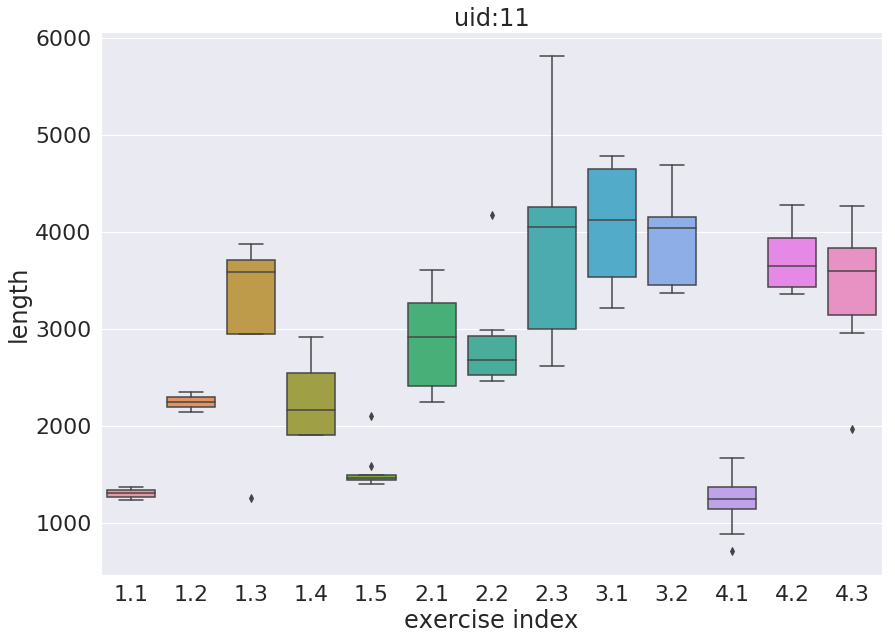

In [13]:
tmp_data = user_cleaned_data.reset_index()[['uid', 'exc_num', 'length']]
people = user_cleaned_data.reset_index()['uid'].unique().tolist()
for person in people:
    tmp = tmp_data[tmp_data['uid']==person]
    
    sns.set_style('whitegrid')
    sns.set(font_scale=2)
    f, ax= plt.subplots(figsize = (14, 10))
    
    ax = sns.boxplot(x="exc_num", y="length", data=tmp)
    ax.set_title('uid:'+str(person))
    ax.set(xlabel='exercise index')

In [16]:
index_without_outlier = user_cleaned_data.reset_index()
index_without_outlier.to_csv('../data/cleaned_index.csv', index=False)